## Tagging github pull requests with `doc2vec`

https://datascience.stackexchange.com/questions/25376/better-input-for-doc2vec
https://medium.com/@klintcho/doc2vec-tutorial-using-gensim-ab3ac03d3a1
https://medium.com/@mishra.thedeepak/doc2vec-in-a-simple-way-fa80bfe81104
https://medium.com/@gofortargets/doc2vec-word2vec-in-gensim-c9321c780079

In [130]:
from deathbeds.__github_data_into_dataframes import pulls
from pandas import *; Concat = concat
from CommonMark.render  import renderer
from CommonMark.render.html  import HtmlRenderer
from CommonMark import Parser
from toolz.curried import *
from toolz.curried.operator import *


## Tokenizing markdown messages

In [131]:
class MarkdownTokenize(renderer.Renderer):
    def __init__(self, *args, **kwargs):
        HtmlRenderer.__init__(self, *args, **kwargs)
        self.codes = []
        
    def code_block(self, node, entering):
        self.codes.append(node.literal)
    
    def __getattr__(self, object):
        def call(node, entering=None):
            self.out(getattr(node, 'literal', None) or '')
        return call
    
    def render(self, object):
        return pandas.Series([super().render(object), self.codes], ['text', 'code'])
    
    softbreak = HtmlRenderer.softbreak

    from gensim.test.utils import common_texts
    from gensim.models.doc2vec import Doc2Vec, TaggedDocument

    documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(common_texts)]
    model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)

In [132]:
prs = pulls('jupyterlab/jupyterlab', iter=10)

df = Concat(list(prs)).set_index('id')
df.index = df.index.astype(str)

In [133]:
df = df.body.apply(lambda x: MarkdownTokenize().render(Parser().parse(x))).join(df)

# Extract references to people, issues, and prs.

In [134]:
df = df.text.str.lower().str.split(r'[ ,;.]').apply(
    lambda x: pipe(
        x, filter(compose(contains('@#'), first)),
        groupby(first), valmap(compose(list, map(itemgetter(slice(1, None))))),
        keymap({'@': 'mentions', '#': 'refs'}.__getitem__), pandas.Series)).join(df)

In [135]:
from nltk import tokenize

In [136]:
df = (df.title + '\n\n' + df.text).apply(tokenize.wordpunct_tokenize).apply(
    compose(list, filter(str.isalnum))
).rename('tokens').to_frame().join(df)

## Compose a document model to extract features from pull requests.

In [228]:
    from gensim.test.utils import common_texts
    from gensim.models.doc2vec import Doc2Vec, TaggedDocument

    documents = [TaggedDocument(doc, id) for doc, id in zip(df.tokens.values, df.index)]
    model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)

## Create a distance matrix

We construct a matrix with the cosine similarity condition.

In [ ]:
D = np.zeros([len(df)]*2)
for i, id in enumerate(df.index):
    for j, id2 in enumerate(df.index[i:]):
        j += i 
        D[j, i] = D[i, j] = model.docvecs.similarity_unseen_docs(model, df.text.loc[id].split(), df.text.loc[id2].split())
similarities = pandas.DataFrame(D, df.index, df.index)

C:\Anaconda3\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


## Preliminary graph views

In [ ]:
from matplotlib.pyplot import *
from networkx import *

In [ ]:
G = from_pandas_adjacency(similarities)

In [219]:
pos = fruchterman_reingold_layout(G)

We cannot split on things that are versions.

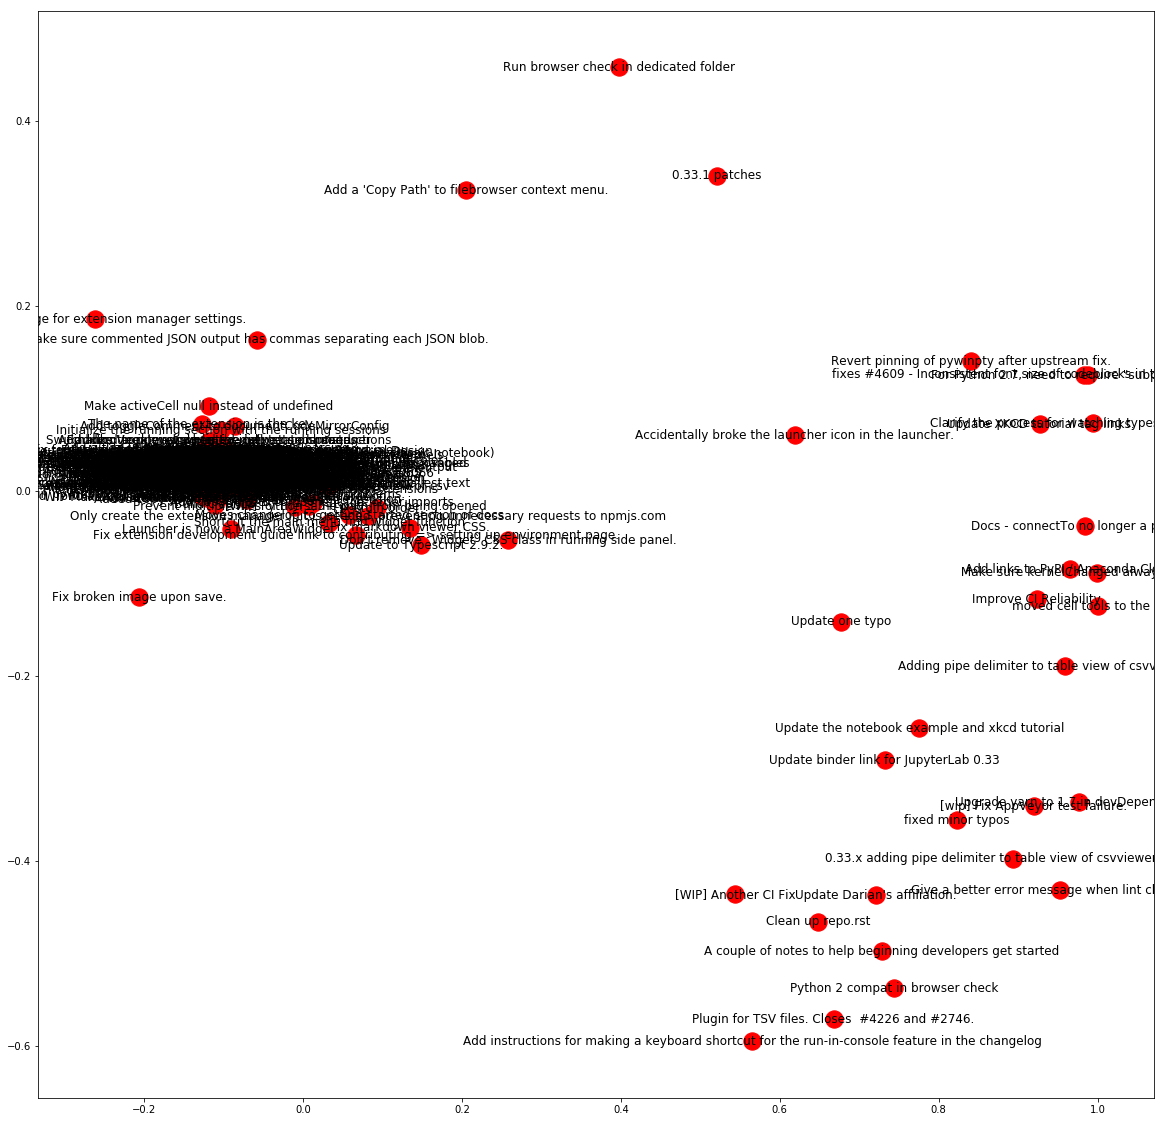

In [220]:
%matplotlib inline
f = figure(figsize=(20, 20))
draw_networkx_labels(G, pos, df.title.to_dict())
draw_networkx_nodes(G, pos)

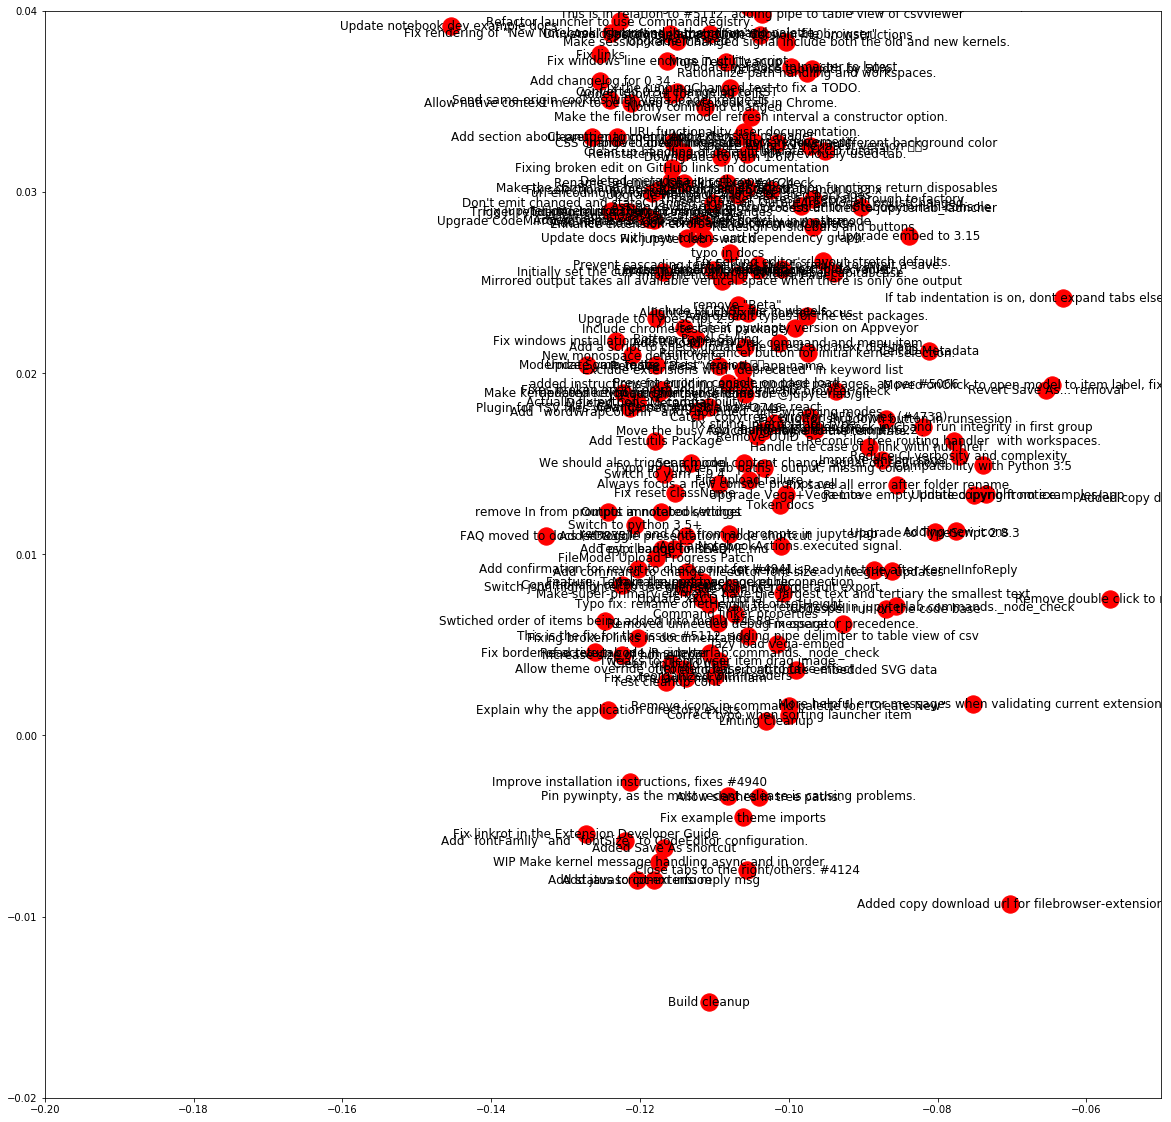

In [227]:
%matplotlib inline
f = figure(figsize=(20, 20))
draw_networkx_labels(G, pos, df.title.to_dict())
draw_networkx_nodes(G, pos)
gca().set_xlim(-.2, -.05)
gca().set_ylim(-.02, .04)